## import

In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import albumentations as A
import torch
import torch.nn.functional as F
import torchinfo
from albumentations.pytorch.transforms import ToTensorV2
from torch.utils.data import DataLoader
from torchlake.common.constants import VOC_CLASS_NAMES
from torchlake.common.utils.convert import img_tensor_to_np
from torchlake.common.utils.image import decode_segmap, load_image
from torchlake.common.utils.plot import plot_grids
from torchlake.common.utils.platform import get_file_size, get_num_workers

from torchlake.common.controller.trainer import ClassificationTrainer
from torchlake.common.datasets.voc import VOCSegmentation
from torchlake.common.datasets.voc.constants import LABEL_COLORS
from torchlake.semantic_segmentation.models.deeplabv3 import DeepLabV3

from tqdm import tqdm

# setting

In [2]:
artifacts_path = Path("../../artifacts/deeplabv3")
artifacts_path.mkdir(exist_ok=True)

data_path = Path("../../data")

In [3]:
DEVICE = torch.device("cuda:0")

# data

In [4]:
BATCH_SIZE = 8
TRAIN_IMAGE_SIZE = 321 # 32k-31
TEST_IMAGE_SIZE = 513 # 32k-31
NUM_CLASS = len(VOC_CLASS_NAMES)

In [5]:
train_transform = A.Compose(
    [
        A.HorizontalFlip(),
        A.Resize(TRAIN_IMAGE_SIZE, TRAIN_IMAGE_SIZE),
        A.Normalize(0, 1),  # in feature extractor
        ToTensorV2(),
    ]
)

test_transform = A.Compose(
    [
        A.Resize(TEST_IMAGE_SIZE, TEST_IMAGE_SIZE),
        A.Normalize(0, 1),  # in feature extractor
        ToTensorV2(),
    ]
)

In [6]:
train_dataset = VOCSegmentation(
    data_path.as_posix(),
    year="2012",
    transform=train_transform,
)

test_dataset = VOCSegmentation(
    data_path.as_posix(),
    year="2007",
    transform=test_transform,
)

In [7]:
NUM_WORKERS = get_num_workers()

In [8]:
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=True,
    num_workers=NUM_WORKERS,
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE // 2,
    num_workers=NUM_WORKERS,
)

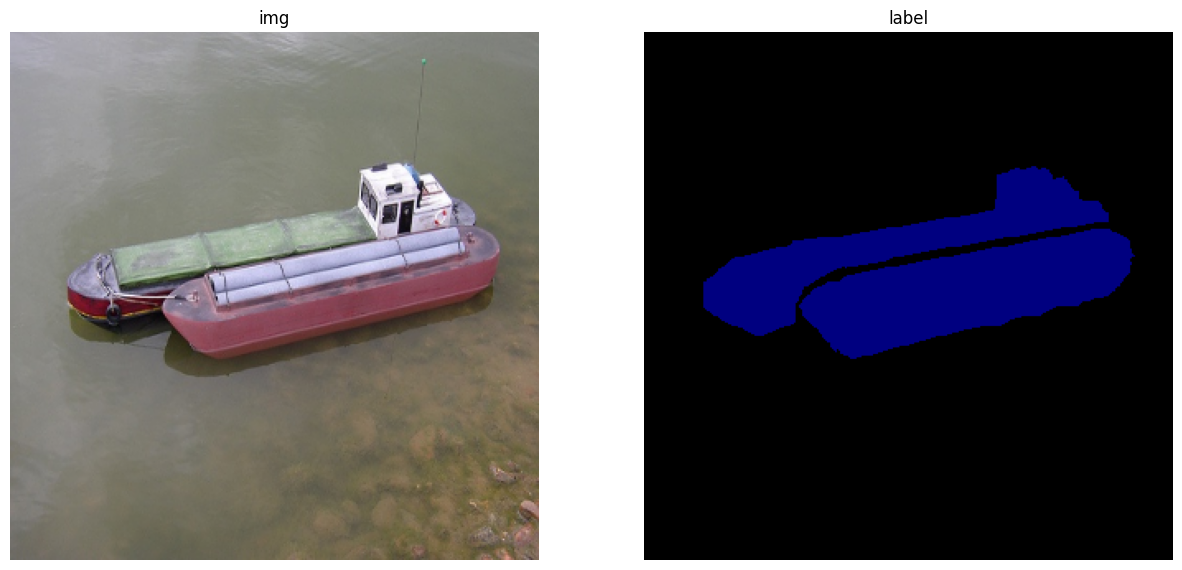

In [9]:
interest_pic = 102
img, label = train_dataset[interest_pic]

plot_grids(
    [
        img_tensor_to_np(img),
        decode_segmap(label, LABEL_COLORS),
    ],
    ["img", "label"],
    1,
    2,
    figsize=(15, 7),
)

In [10]:
row = next(iter(train_loader))
for ele in row: print(ele.shape)

torch.Size([8, 3, 321, 321])
torch.Size([8, 321, 321])


# train

In [11]:
model = DeepLabV3(
    output_size=NUM_CLASS + 1,
    backbone_name="resnet101",
    neck_type="cascade",
    frozen_backbone=True,
).to(DEVICE)

In [12]:
torchinfo.summary(model)

Layer (type:depth-idx)                                       Param #
DeepLabV3                                                    --
├─ResNetFeatureExtractor: 1-1                                --
│    └─Sequential: 2-1                                       --
│    │    └─Sequential: 3-1                                  (9,536)
│    │    └─Sequential: 3-2                                  (215,808)
│    │    └─Sequential: 3-3                                  (1,219,584)
│    │    └─Sequential: 3-4                                  (26,090,496)
│    │    └─Sequential: 3-5                                  (14,964,736)
│    │    └─AdaptiveAvgPool2d: 3-6                           --
│    └─ImageNetNormalization: 2-2                            --
├─CascadeASPP: 1-2                                           --
│    └─Sequential: 2-3                                       --
│    │    └─Sequential: 3-7                                  13,387,776
│    │    └─Sequential: 3-8                       

In [13]:
EPOCHES = 10

In [14]:
trainer = ClassificationTrainer(EPOCHES, DEVICE)

In [15]:
criterion = trainer.get_criterion(NUM_CLASS)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [16]:
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2, threshold=.05 ,threshold_mode ='rel')

In [17]:
training_loss = trainer.run(train_loader, model, optimizer, criterion, scheduler)

100%|██████████| 364/364 [01:57<00:00,  3.09it/s]


epoch 1 : 0.10289521000583421


100%|██████████| 364/364 [01:56<00:00,  3.13it/s]


epoch 2 : 0.07244919866814718


100%|██████████| 364/364 [01:56<00:00,  3.13it/s]


epoch 3 : 0.06202761807407324


100%|██████████| 364/364 [01:56<00:00,  3.13it/s]


epoch 4 : 0.058301254554273006


100%|██████████| 364/364 [01:56<00:00,  3.13it/s]


epoch 5 : 0.05530069652781054


100%|██████████| 364/364 [02:00<00:00,  3.02it/s]


epoch 6 : 0.05252750459956108


100%|██████████| 364/364 [02:01<00:00,  2.99it/s]


epoch 7 : 0.049148839949579026


100%|██████████| 364/364 [02:01<00:00,  3.00it/s]


epoch 8 : 0.04716677481697484


100%|██████████| 364/364 [02:01<00:00,  3.00it/s]


epoch 9 : 0.045722731430042574


100%|██████████| 364/364 [02:01<00:00,  2.99it/s]

epoch 10 : 0.04330256582329889


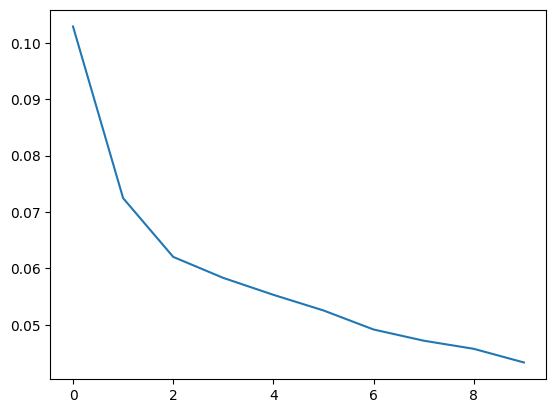

In [18]:
plt.plot(training_loss)

In [19]:
model_path = artifacts_path.joinpath('deeplabv3.resnet101.cascade.pth')

In [20]:
torch.save(model.state_dict(), model_path)

In [21]:
get_file_size(model_path)

'318.27MiB'

In [22]:
model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

# inference

### dice coef

In [23]:
from torchmetrics.classification import jaccard

In [24]:
metric = jaccard.MulticlassJaccardIndex(NUM_CLASS + 1, average=None)

model.eval()
with torch.no_grad():
    for img, labels in tqdm(test_loader):
        img = img.to(DEVICE)

        # B, C+1, H, W
        output = model(img)
        output = output.argmax(dim=1).detach().cpu()

        labels = labels.long()
        metric.update(output, labels)

100%|██████████| 158/158 [00:40<00:00,  3.93it/s]


In [25]:
for class_name, value in zip(VOC_CLASS_NAMES, metric.compute()[1:].mul(100).round().tolist()):
    print("{:<15}: {:<5}".format(class_name, value / 100))

print("----------------------")
print("{:<15}: {:<5}".format("total", metric.compute()[1:].mean().mul(100).round().item()/100))

aeroplane      : 0.64 
bicycle        : 0.08 
bird           : 0.69 
boat           : 0.54 
bottle         : 0.55 
bus            : 0.65 
car            : 0.59 
cat            : 0.73 
chair          : 0.16 
cow            : 0.47 
diningtable    : 0.55 
dog            : 0.58 
horse          : 0.51 
motorbike      : 0.63 
person         : 0.69 
pottedplant    : 0.31 
sheep          : 0.61 
sofa           : 0.16 
train          : 0.7  
tvmonitor      : 0.54 
----------------------
total          : 0.52 


(<Figure size 640x480 with 1 Axes>, <Axes: ylabel='MulticlassJaccardIndex'>)

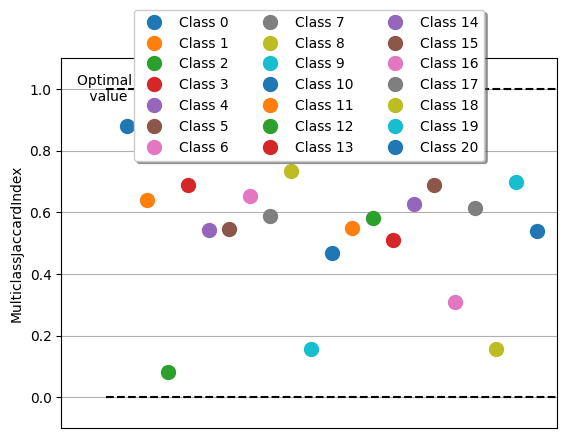

In [26]:
metric.plot()

### for image in dataset

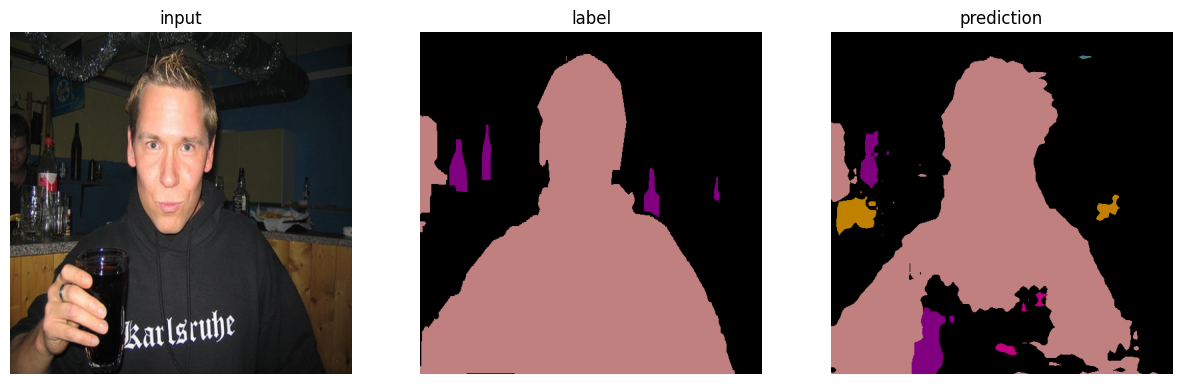

In [27]:
interest_pic = 10

model.eval()
with torch.no_grad():
    target_img, target_label = test_dataset[interest_pic]

    output = model(target_img.unsqueeze(0).to(DEVICE))
    output = output.squeeze(0).permute(1, 2, 0).argmax(dim=2).detach().cpu()

plot_grids(
    [
        img_tensor_to_np(target_img),
        decode_segmap(target_label.numpy(), LABEL_COLORS),
        decode_segmap(output.numpy(), LABEL_COLORS),
    ],
    ["input", "label", "prediction"],
    1,
    3,
    figsize=(15, 15),
)

### for any image

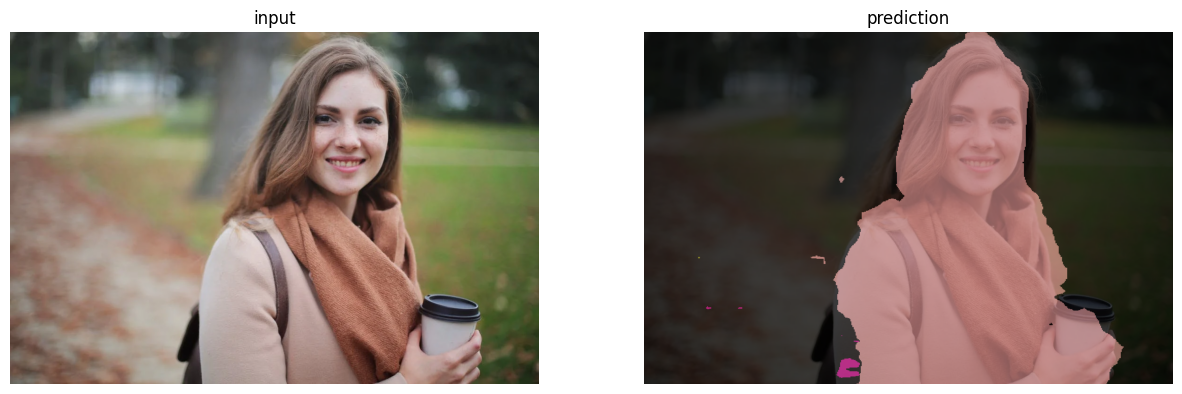

In [28]:
model.eval()
with torch.no_grad():
    target_img = load_image(data_path.joinpath("person.webp"), is_numpy=True)

    h, w, c = target_img.shape
    test_img = test_transform(image=target_img)["image"]
    output = model(test_img.unsqueeze(0).to(DEVICE))
    output = output.argmax(dim=1, keepdim=True)
    # B, C, H, W
    output = F.interpolate(output.float(), size=(h, w), mode="nearest")
    # 1, 1, h, w
    output = output.squeeze(0, 1).detach().cpu().numpy()

    coef = 0.7
    mask = decode_segmap(output, LABEL_COLORS)
    overlay_image = target_img.copy()
    for channel_idx in range(c):
        overlay_image[: , : ,channel_idx] = overlay_image[: , : ,channel_idx] * (1 - coef) + mask[: , : ,channel_idx] * coef


    plot_grids(
        [
            target_img,
            overlay_image,
        ],
        ["input", "prediction"],
        1,
        2,
        figsize=(15, 15),
    )